# Goal and principles behind PNPULA
 
The goal of this notebook is to solve the inverse problem 

$$
y = Ax + n \ ,
$$

where $A$ is linear forward operator encoding a blur/convolution operation, $n$ is some additive noise with $n \sim \mathcal{N} (0, \sigma^2 I) $ and $y$ is the blurry observation of $y$.

**Goal:** Retrieve $x$ from $y$.

**Problem position:**

- *Likelihood:* Gaussian with density $\pi_{Y|X=x}(y) \propto \exp (- \frac{1}{2\sigma^2} \| Ax - y\|_2^2)$.
- *Prior:* $\pi_X (x)$ of natural images.

Applying Bayes's rule, we can define a posterior distribution with density $\pi_{X|Y=y}(x) \propto \pi_X(x) \pi_{Y|X=x}(y)$.

**Implicit prior defined by Gaussian convolution:** 

We do not have access to $\pi_X$. Let us consider a smooth version of $\pi_X$ resulting from the convolution between $\pi_X$ and a Gaussian kernel $g_\alpha$ with zero mean and $\alpha I$ covariance matrix. We denote it $\pi_X^\alpha$ and define it as follows 

$$
\forall x_\alpha \in \mathbb{R}^d, \ \pi_X^{\alpha} (x_\alpha) = (\pi_X * g_\alpha )(x_\alpha) = \int_{\mathbb{R}^d} \pi_X(x) g_\alpha (x_\alpha-x)dx = \int_{\mathbb{R}^d} \pi_X(x) \exp (-\|x_\alpha-x\|_2^2/2\alpha) dx / Z \ ,
$$

with $Z$ the normalization constant.

*Remark:* As long as we don't have access to $\pi_X$, we cannot compute $\pi_X^\alpha$. Furthermore, even if we had access to $\pi_X$, computing $\pi_X^\alpha(x)$ would require to estimate a high-dimensional integral which is not doable in practice.

*Remark:* According to the definition of $\pi_X^\alpha$, we have $X_\alpha = X + \sqrt{\alpha} B$ with $B \sim \mathcal{N}(0, I)$. 

$\forall x_\alpha \in \mathbb{R}^d$, we have

\begin{align}
    \nabla_x \log \pi_X^\alpha(x_\alpha) &= \nabla_x [\pi_X^\alpha (x_\alpha)]/\pi_X^\alpha (x_\alpha) \\
    &= \nabla_x [\int_{\mathbb{R}^d} \pi_X(x) \exp (-\|x_\alpha-x\|_2^2/2\alpha) dx] /\pi_X^\alpha (x_\alpha) \\
    &= \int_{\mathbb{R}^d} \nabla_x [\pi_X(x) \exp (-\|x_\alpha-x\|_2^2/2\alpha)] dx /\pi_X^\alpha (x_\alpha) \\
    &= -\int_{\mathbb{R}^d} \pi_X(X) (x_\alpha-x) \exp (-\|x_\alpha-x\|_2^2/2\alpha) dx /\alpha \pi_X^\alpha (x_\alpha) \\
    &= \frac{1}{\alpha}[\int_{\mathbb{R}^d} x \pi_X(x) \exp (-\|x_\alpha-x\|_2^2/2\alpha) dx / \pi_X^\alpha (x_\alpha) - x_\alpha \int_{\mathbb{R}^d} \pi_X(x) \exp (-\|x_\alpha-x\|_2^2/2\alpha) dx / \pi_X^\alpha (x_\alpha)] \\
    &= \frac{1}{\alpha} [\int_{\mathbb{R}^d} x \pi_X(x) \exp (-\|x_\alpha-x\|_2^2/2\alpha) dx / \pi_X^\alpha (x_\alpha) - x_\alpha ] \\
    &= \frac{1}{\alpha} [ \mathbb{E}_{\pi_{X|X_\alpha = x_\alpha}}[X|X_\alpha=x_\alpha] - x_\alpha ]
\end{align}

Then, to compute $\nabla \log \pi_X^\alpha$, we need to estimate the MMSE for the denoising inverse problem $X_\alpha = X + \alpha B $, ie $\mathbb{E}[X|X_\alpha=x_\alpha]$.

Consequently, the smoothed prior $\pi_X^\alpha$ is only defined via a MMSE denoising algorithm. Knowing this quantity we can apply any gradient based algorithm involving $\nabla \log \pi_X^\alpha$.  

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error as mse
import cuqi
from cuqi.testproblem import Deconvolution2D
from cuqi.distribution import Gaussian, Posterior
from cuqi.implicitprior import RestorationPrior
from cuqi.experimental.mcmc import PnPULANew
import torch
import deepinv as dinv
from mpl_toolkits.axes_grid1 import make_axes_locatable


from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import mean_squared_error as mse

/home/remi/Documents/post_doc/code/implicit_prior_paper/my_fork/CUQIpy/cuqi/implicitprior/_restorator.py:82: SyntaxWarning: invalid escape sequence '\l'
  """


# Inverse problem definition

We consider a deconvolution inverse problem given by 

$$
\mathbf{y} = \mathbf{A} \mathbf{x} + n \ ,
$$
with $n\sim\mathcal{N}(0, \texttt{sigma2}\  I)$.

See: class:`~cuqi.testproblem.Deconvolution2D` for more details.

In [3]:
A,y_obs,info=Deconvolution2D().get_components()

In the next cell we aim at normalizing the images.

In [4]:
info.exactSolution=info.exactSolution/np.max(info.exactSolution)
info.exactData=A(info.exactSolution)

We set the noise level to `sigma=5/255`.

In [5]:
sigma=5/255.
sigma2=sigma**2

We generate the observation `y_obs`. In order to get reproducible results we set the seed to `0`.

In [6]:
np.random.seed(0)
y_obs=info.exactData+sigma*np.random.normal(loc=0,scale=1,size=info.exactData.shape)

We show the observation and the exact solution.

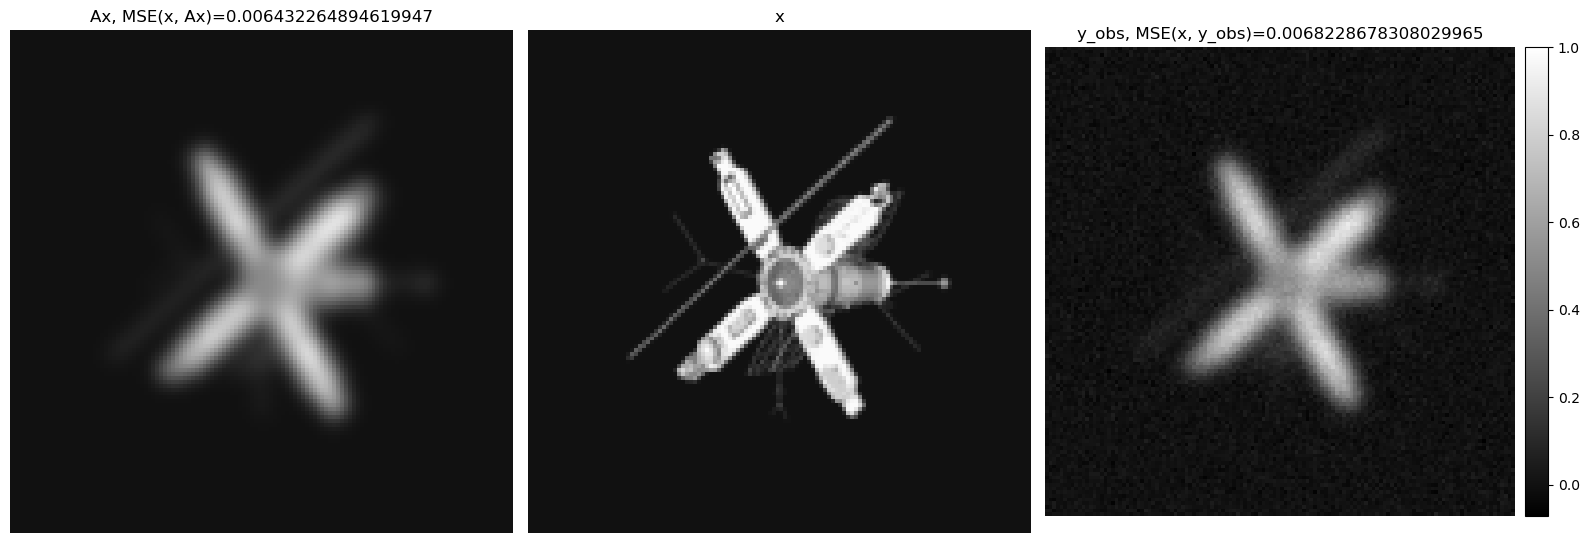

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 16))
# Find the global min and max values to normalize all images equally
vmin = min(info.exactData.min(), info.exactSolution.min(), y_obs.min())
vmax = max(info.exactData.max(), info.exactSolution.max(), y_obs.max())
# Plot each image
im1 = axes[0].imshow(np.reshape(info.exactData, (128, 128)), cmap="gray", vmin=vmin, vmax=vmax)
axes[0].set_title("Ax, MSE(x, Ax)={}".format(mse(info.exactData, info.exactSolution)))
axes[0].axis("off")
im2 = axes[1].imshow(np.reshape(info.exactSolution, (128, 128)), cmap="gray", vmin=vmin, vmax=vmax)
axes[1].set_title("x")
axes[1].axis("off")
im3 = axes[2].imshow(np.reshape(y_obs, (128, 128)), cmap="gray", vmin=vmin, vmax=vmax)
axes[2].set_title("y_obs, MSE(x, y_obs)={}".format(mse(y_obs, info.exactSolution)))
axes[2].axis("off")
# Create an axis for the colorbar and adjust the layout
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
# Add the colorbar
cbar = fig.colorbar(im3, cax=cax)

# Adjust layout to ensure titles and labels fit well
plt.tight_layout()

## Likelihood definition
We first specify the data distribution as follows:

In [8]:
y=Gaussian(mean=A, cov=sigma2)

Then we can definition the likelihood with:

In [9]:
likelihood=y(y=y_obs)

## Implicit prior definition

Regularization and smoothing parameters definition `strength_reg` and `smoothing_strength`.

In [10]:
strength_reg=1
restoration_strength=sigma2/5

## MMSE denoiser defintion.

We illustrate its effect on a denoising inverse problem with additive Gaussian noise with magnitude $s=0.1$.
We show the effect of the denoising strengh.

Text(0.5, 1.0, 'Denoiser with s=$\\sigma$ (MSE=0.003889814396097607)')

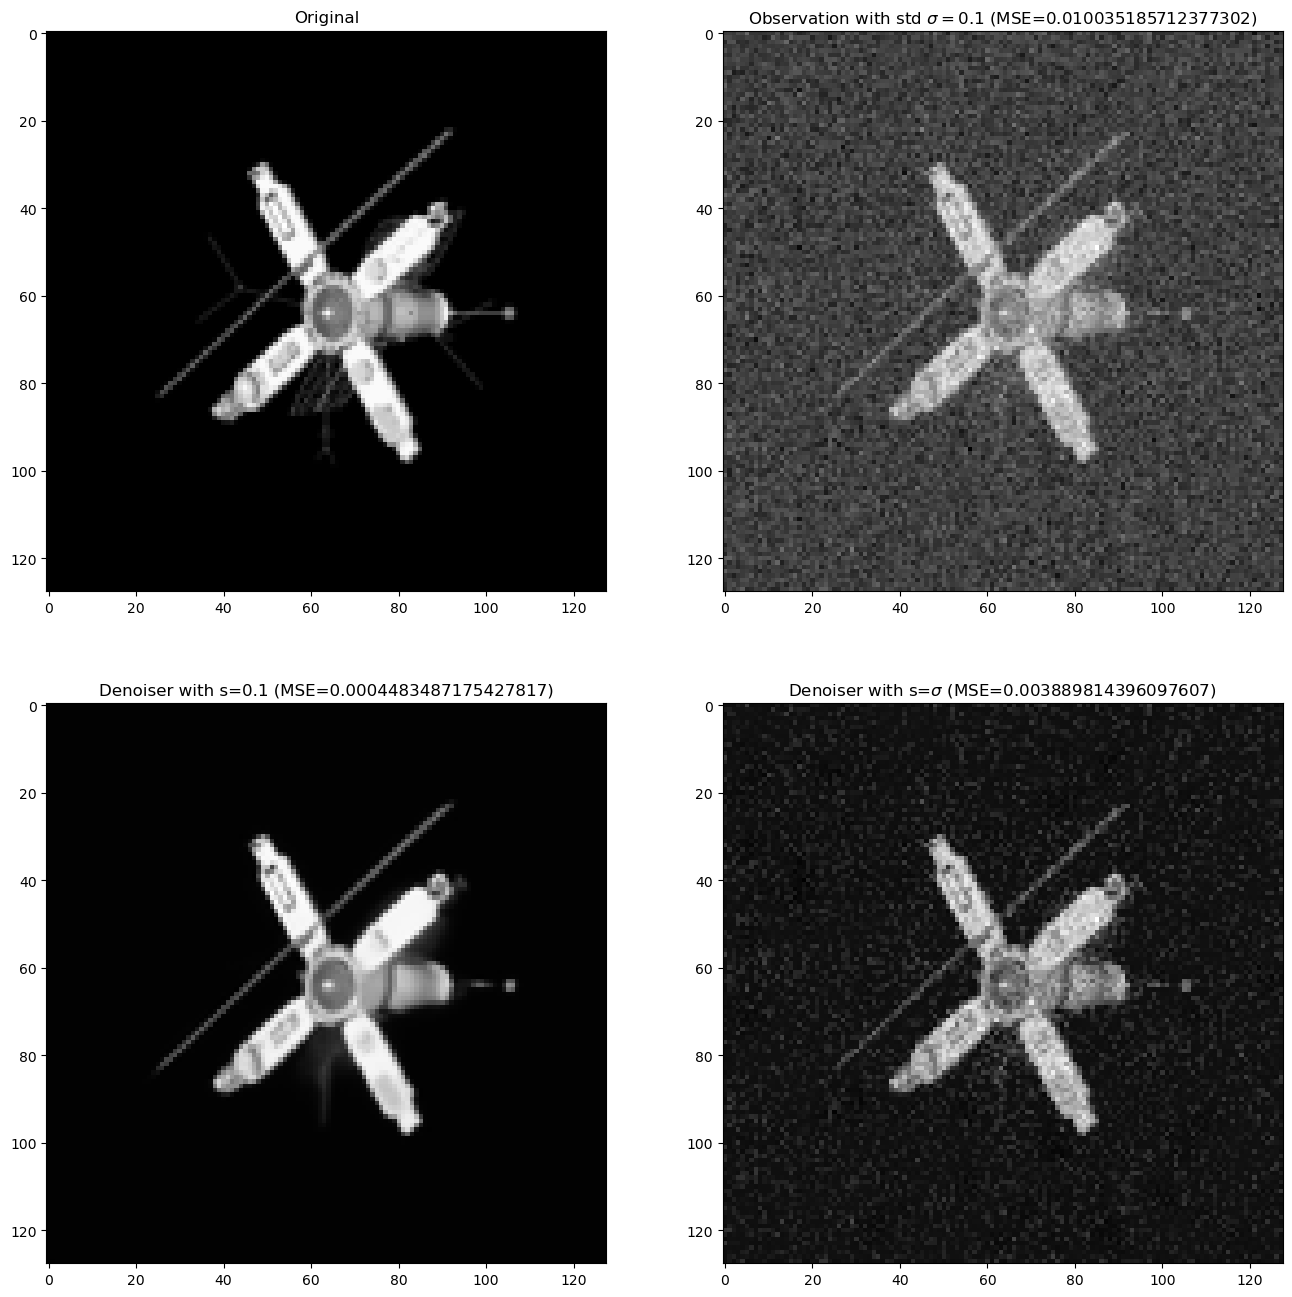

In [11]:
N=int(np.sqrt(info.exactSolution.shape[0]))

from deepinv.models import DRUNet
device="cuda:0" if torch.cuda.is_available() else "cpu"
dinv_denoiser=DRUNet(in_channels=1,out_channels=1,pretrained="download",device=device)
def denoiser(x, restoration_strength=None, strength_reg=None):
    xt=torch.tensor(np.reshape(x,(N,N)), device=device, dtype=torch.float32)
    xt=xt.unsqueeze(0).unsqueeze(0)
    xrt=dinv_denoiser(xt,np.sqrt(restoration_strength))
    xrt=torch.squeeze(xrt)
    xr=xrt.cpu().detach().numpy()
    return xr.flatten(), None

    
s=0.1
xt=torch.tensor(np.reshape(info.exactSolution, (N,N)), device=device, dtype=torch.float32)
xt=xt.unsqueeze(0).unsqueeze(0)
yt=xt+s*torch.randn(xt.shape, device=device)
xrt=dinv_denoiser(yt, s)
xr=torch.squeeze(xrt)
xr=xr.cpu().detach().numpy()

xr2t=dinv_denoiser(yt, sigma)
xr2=torch.squeeze(xr2t)
xr2=xr2.cpu().detach().numpy()
y=torch.squeeze(yt)
y=y.cpu().numpy()
fig=plt.figure(figsize=(16,16))
ax1=fig.add_subplot(2,2,1)
ax1.imshow(np.reshape(info.exactSolution, (N, N)), cmap="gray")
ax1.set_title("Original")
ax2=fig.add_subplot(2,2,2)
ax2.imshow(y, cmap="gray")
ax2.set_title(r"Observation with std $\sigma={}$ (MSE={})".format(s, mse(np.reshape(info.exactSolution, (N, N)), y)))
ax3=fig.add_subplot(2,2,3)
ax3.imshow(xr, cmap="gray")
ax3.set_title("Denoiser with s={} (MSE={})".format(s, mse(np.reshape(info.exactSolution, (N, N)), xr)))
ax4=fig.add_subplot(2,2,4)
ax4.imshow(xr2, cmap="gray")
ax4.set_title(r"Denoiser with s=$\sigma$ (MSE={})".format(mse(np.reshape(info.exactSolution, (N, N)), xr2)))

We save all the important variables into the variable `restorator_kwargs`.

In [12]:
restorator_kwargs={}
restorator_kwargs["strength_reg"]=strength_reg

Now we can define our implicit RestroationPrior.

In [13]:
restorator=RestorationPrior(
    denoiser,
    restoration_strength=restoration_strength,
    restorator_kwargs=restorator_kwargs,
    geometry=likelihood.model.domain_geometry
)

## Effect of the `restorator` on a denoising problem

MSE(Ax, y_obs)/MSE(Ax, D(y_obs)) =  3.1600562240929935


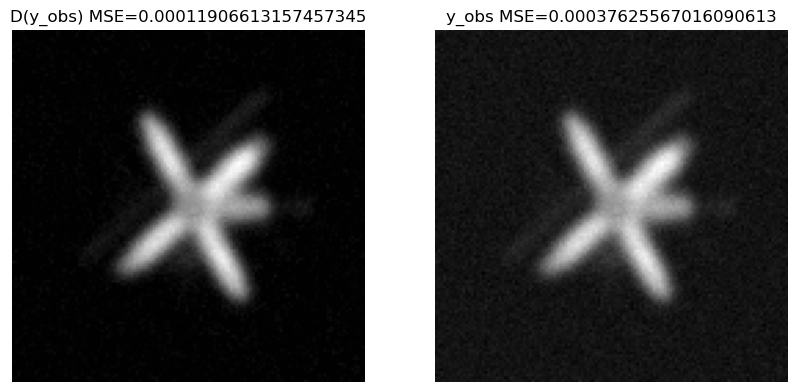

In [14]:
y_res=restorator.restorate(y_obs)
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(1,2,1)
ax1.imshow(np.reshape(y_res, (N, N)), cmap="gray")
ax1.set_title("D(y_obs) MSE={}".format(mse(info.exactData,y_res)))
ax1.axis("off")
ax2=fig.add_subplot(1,2,2)
ax2.imshow(np.reshape(y_obs, (N, N)), cmap="gray")
ax2.set_title("y_obs MSE={}".format(mse(info.exactData,y_obs)))
ax2.axis("off")

print("MSE(Ax, y_obs)/MSE(Ax, D(y_obs)) = ", mse(info.exactData,y_obs)/mse(info.exactData,y_res))

## Implicit posterior distribution

We can now define the implicitly defined posterior distribution.

In [15]:
posterior=Posterior(likelihood, restorator)

## Parameters of the PnPULA sampler

We let run PnPULA for `Ns=5000` iterations. We discard the first `Nb=1000` samples.
As we cannot estimate the Lipschitz constant of the NLMeans denoiser, we set `scale=0.00001`.

In [16]:
scale=0.00001
Ns=5000
Nb=1000

In order to get reproducible results, we set the seed parameter to 0.

In [17]:
np.random.seed(0)

## PnP-ULA sampler
Definition of the PnP-ULA sampler.

In [18]:
pnpula_sampler=PnPULANew(target=posterior, scale=scale, smoothing_strength=restoration_strength)

Sampling with PnP-ULA.

In [19]:
pnpula_sampler.sample(Ns=Ns)

  0% (0 of 5000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (3 of 5000) |                       | Elapsed Time: 0:00:00 ETA:   0:02:56
  0% (7 of 5000) |                       | Elapsed Time: 0:00:00 ETA:   0:02:47
  0% (11 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:02:42
  0% (15 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:02:41
  0% (19 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:02:40
  0% (23 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:02:39
  0% (27 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:02:39
  0% (31 of 5000) |                      | Elapsed Time: 0:00:00 ETA:   0:02:38
  0% (35 of 5000) |                      | Elapsed Time: 0:00:01 ETA:   0:02:37
  0% (39 of 5000) |                      | Elapsed Time: 0:00:01 ETA:   0:02:37
  0% (43 of 5000) |                      | Elapsed Time: 0:00:01 ETA:   0:02:37
  0% (47 of 5000) |                     

 Sampler: 
	 PnPULANew 
 Target: 
 	 Posterior(
    Equation:
	 p(restorator|y) ∝ L(restorator|y)p(restorator)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	restorator ~ CUQI RestorationPrior.
 ) 
 Current state: 
	 current_point: [-0.01898957 -0.01335678  0.01984925 ...  0.00217127  0.00084449
  0.00249414] 
	 current_target_grad: [ 249.26408569  174.53352352 -255.77155317 ...  -26.2752266    -8.4126591
  -29.4118932 ] 
	 scale: 1e-05 

In [20]:
samples=pnpula_sampler.get_samples()
samples_warm=samples.burnthin(Nb=Nb)

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'x2964'}>,
        <Axes: title={'center': 'x350'}>,
        <Axes: title={'center': 'x6624'}>],
       [<Axes: title={'center': 'x7159'}>,
        <Axes: title={'center': 'x7783'}>, <Axes: >]], dtype=object)

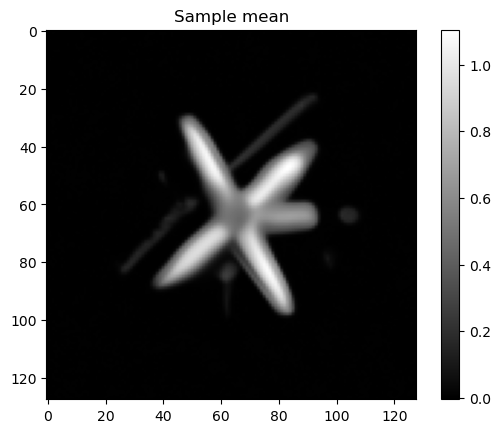

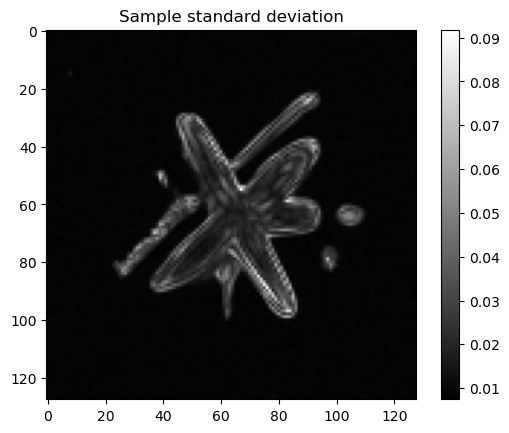

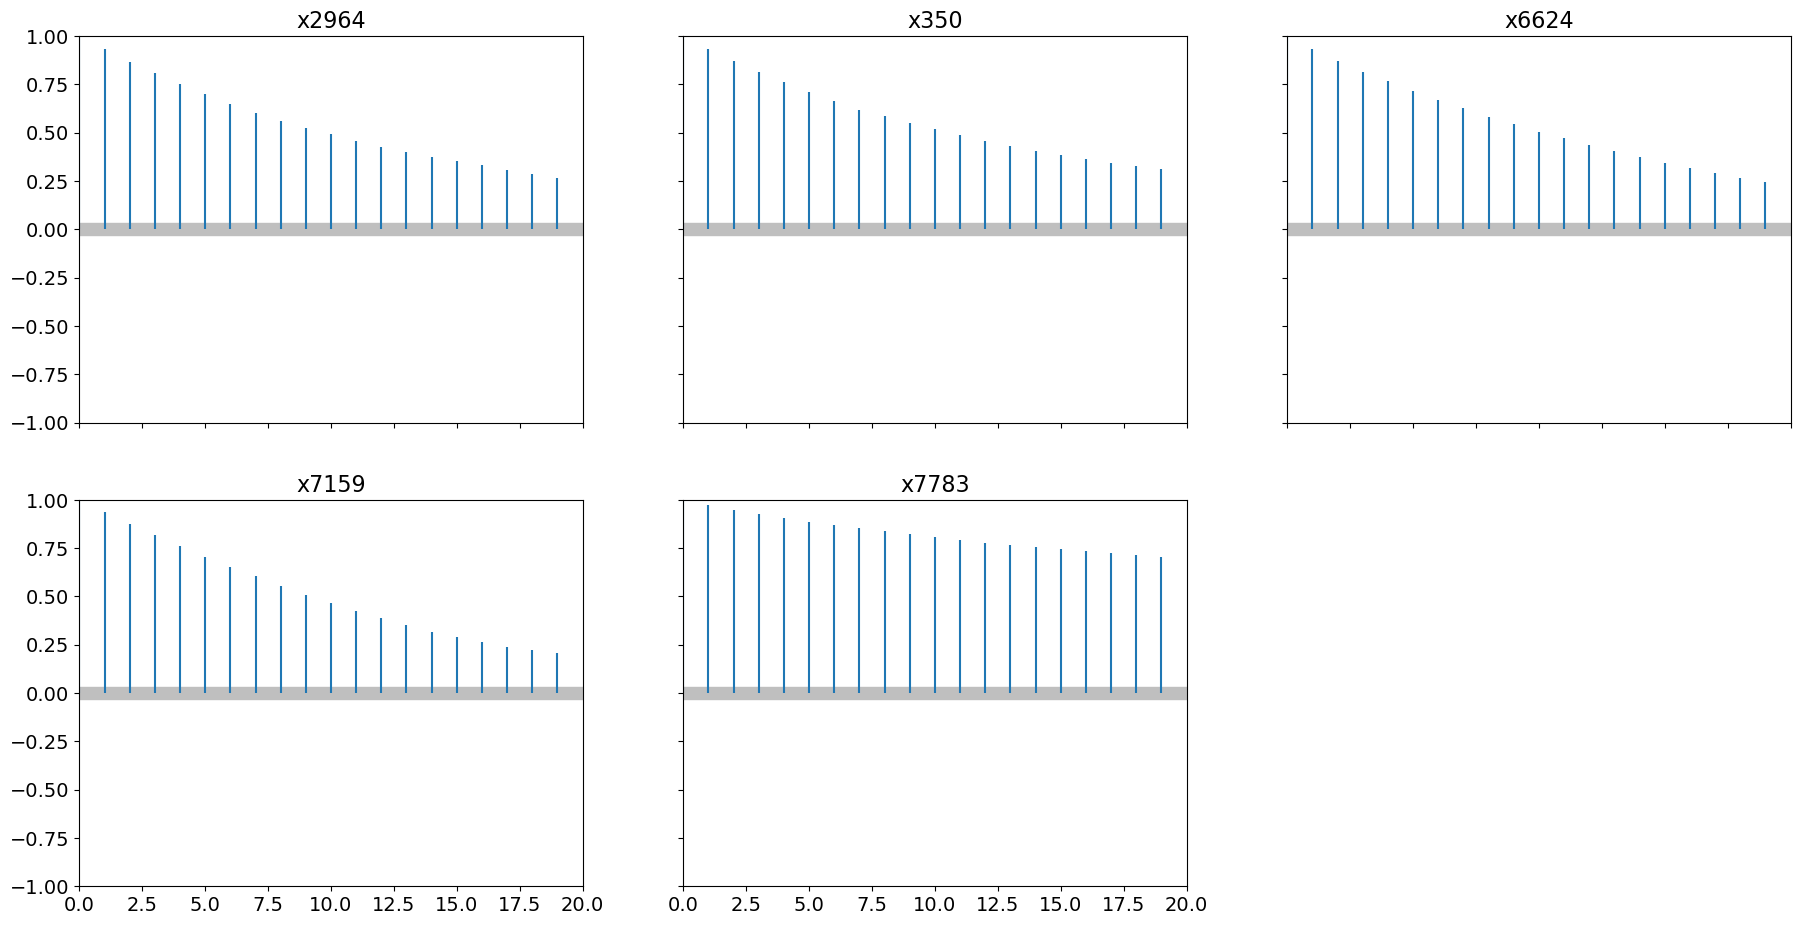

In [21]:
plt.figure()
samples_warm.plot_mean()
plt.colorbar()

plt.figure()
samples_warm.plot_std()
plt.colorbar()

samples_warm.plot_autocorrelation(max_lag=20)